# Robustness to Noise and Dropout

Work in progress

Effect of gaussian noise and/or dropout during training phase on model's performance.

DONE:
* noise implementation
* dropout implementation
* main testing loop
* improve histogram visualisation (equal bins, opacity)


TODO:
* check if dropout causes more neurons to spike
* noise robustness vs depth

## Imports

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm

import torch
import torch.nn as nn

from tqdm.auto import tqdm as pbar

dtype = torch.float

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")

## Hyperparameters

In [37]:
# Constants
SECONDS = 1
MS = 1e-3
HZ = 1

DT = 1 * MS            # large time step to make simulations run faster
ANF_PER_EAR = 100    # repeats of each ear with independent noise

DURATION = .1 * SECONDS # stimulus duration
DURATION_STEPS = int(np.round(DURATION / DT))
INPUT_SIZE = 2 * ANF_PER_EAR
mu, sigma = 0, 0.5  # gaussian noise for phase delay

# Training 
LR = 0.005
N_EPOCHS = 20
batch_size = 64
n_training_batches = 64
n_testing_batches = 32
num_samples = batch_size*n_training_batches
dropout_prob = 0.5
RUNS = 3

# classes at 15 degree increments
NUM_CLASSES = 180 // 15
print(f'Number of classes = {NUM_CLASSES}')

# Network
NUM_HIDDEN = 30 # number of hidden units
TAU = 5 # membrane time constant
IE_RATIO = 0.5 # ratio of inhibitory:excitatory units (used if DALES_LAW = True). 0 = all excitatory, 1 = all inhibitory 
DALES_LAW = False # When True, units will be only excitatory or inhibitory. When False, units will use both (like a normal ANN) 
if DALES_LAW:
    print('Using Dales Law')

Number of classes = 12


## Functions

### Stimulus

In [38]:
def input_signal(ipd, sigma=sigma, mu=mu):
    """
    Generate an input signal (spike array) from array of true IPDs
    """
    envelope_power = 2   # higher values make sharper envelopes, easier
    rate_max = 600 * HZ   # maximum Poisson firing rate
    stimulus_frequency = 20 * HZ

    num_samples = len(ipd)
    times = np.arange(DURATION_STEPS) * DT # array of times
    phi = 2*np.pi*(stimulus_frequency * times + np.random.rand()) # array of phases corresponding to those times with random offset
    # each point in the array will have a different phase based on which ear it is
    # and its delay
    theta = np.zeros((num_samples, DURATION_STEPS, 2*ANF_PER_EAR))
    # for each ear, we have ANF_PER_EAR different phase delays from to pi/2 so
    # that the differences between the two ears can cover the full range from -pi/2 to pi/2
    phase_delays = np.linspace(0, np.pi/2, ANF_PER_EAR)
    # add gaussian noise to phase delays
    phase_noise = np.random.normal(mu, sigma, 2*ANF_PER_EAR)
    noisy_delays_l = phase_delays + phase_noise[:ANF_PER_EAR]
    noisy_delays_r = phase_delays + phase_noise[ANF_PER_EAR:]
    # now we set up these theta to implement that. Some numpy vectorisation logic here which looks a little weird,
    # but implements the idea in the text above.
    theta[:, :, :ANF_PER_EAR] = phi[np.newaxis, :, np.newaxis]+noisy_delays_l[np.newaxis, np.newaxis, :]
    theta[:, :, ANF_PER_EAR:] = phi[np.newaxis, :, np.newaxis]+noisy_delays_r[np.newaxis, np.newaxis, :]+ipd[:, np.newaxis, np.newaxis]
    # now generate Poisson spikes at the given firing rate as in the previous notebook
    spikes = np.random.rand(num_samples, DURATION_STEPS, 2*ANF_PER_EAR)<rate_max*DT*(0.5*(1+np.sin(theta)))**envelope_power
    return spikes

def random_ipd_input_signal(num_samples, tensor=True, sigma=sigma):
    """
    Generate the training data
    Returns true IPDs from U(-pi/2, pi/2) and corresponding spike arrays
    """
    ipd = np.random.rand(num_samples)*np.pi-np.pi/2 # uniformly random in (-pi/2, pi/2)
    spikes = spikes_from_fixed_idp_input_signal(ipd, tensor, sigma=sigma)

    if tensor:
        ipd = torch.tensor(ipd, device=device, dtype=dtype)        

    return ipd, spikes

def spikes_from_fixed_idp_input_signal(ipd, tensor=True, sigma=sigma):
    spikes = input_signal(ipd, sigma=sigma)
    if tensor:
        spikes = torch.tensor(spikes, device=device, dtype=dtype)
    return spikes

def show_examples(shown=8):
    ipd = np.linspace(-np.pi/2, np.pi/2, shown)
    spikes = spikes_from_fixed_idp_input_signal(ipd, shown).cpu()

    plt.figure(figsize=(10, 4), dpi=100)
    for i in range(shown):
        plt.subplot(2, shown // 2, i+1)
        plt.imshow(spikes[i, :, :].T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
        plt.title(f'True IPD = {int(ipd[i]*180/np.pi)} deg')
        if i>=4:
            plt.xlabel('Time (steps)')
        if i%4==0:
            plt.ylabel('Input neuron index')
    plt.tight_layout()

def data_generator(ipds, spikes):
    perm = torch.randperm(spikes.shape[0])
    spikes = spikes[perm, :, :]
    ipds = ipds[perm]
    n, _, _ = spikes.shape
    n_batch = n//batch_size
    for i in range(n_batch):
        x_local = spikes[i*batch_size:(i+1)*batch_size, :, :]
        y_local = ipds[i*batch_size:(i+1)*batch_size]
        yield x_local, y_local
        
def discretise(ipds):
    return ((ipds+np.pi/2) * NUM_CLASSES / np.pi).long() # assumes input is tensor

def continuise(ipd_indices): # convert indices back to IPD midpoints
    return ((ipd_indices+0.5) / NUM_CLASSES * np.pi - np.pi / 2) #* (NUM_CLASSES+1) / NUM_CLASSES

### SNN 

In [39]:
def sigmoid(x, beta):
    return 1 / (1 + torch.exp(-beta*x))

def sigmoid_deriv(x, beta):
    s = sigmoid(x, beta)
    return beta * s * (1 - s)

class SurrGradSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, inp):
        ctx.save_for_backward(inp)
        out = torch.zeros_like(inp)
        out[inp > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        inp, = ctx.saved_tensors
        sigmoid_derivative = sigmoid_deriv(inp, beta=5)
        grad = grad_output*sigmoid_derivative
        return grad

spike_fn  = SurrGradSpike.apply

def membrane_only(input_spikes, weights, tau):
    """
    :param input_spikes: has shape (batch_size, duration_steps, input_size)
    :param weights: has shape  (input_size, num_classes
    :param tau: 
    :return: 
    """
    batch_size = input_spikes.shape[0]
    assert len(input_spikes.shape) == 3
    
    v = torch.zeros((batch_size, NUM_CLASSES), device=device, dtype=dtype)
    v_rec = [v]
    h = torch.einsum("abc,cd->abd", (input_spikes, weights))
    alpha = np.exp(-DT / tau)
    for t in range(DURATION_STEPS - 1):
        v = alpha*v + h[:, t, :]
        v_rec.append(v)
    v_rec = torch.stack(v_rec, dim=1)  # (batch_size, duration_steps, num_classes)
    return v_rec

def layer1(input_spikes, w1, tau, sign1):
    
    if DALES_LAW:
        w1 = get_signed_weights(w1, sign1)

    batch_size = input_spikes.shape[0]

    # First layer: input to hidden
    v = torch.zeros((batch_size, NUM_HIDDEN), device=device, dtype=dtype)
    s = torch.zeros((batch_size, NUM_HIDDEN), device=device, dtype=dtype)
    s_rec = [s]
    h = torch.einsum("abc,cd->abd", (input_spikes, w1))
    alpha = np.exp(-DT / tau)
    
    for t in range(DURATION_STEPS - 1):
        new_v = (alpha*v + h[:, t, :])*(1-s) # multiply by 0 after a spike
        s = spike_fn(v-1) # threshold of 1
        v = new_v
        s_rec.append(s)
    s_rec = torch.stack(s_rec, dim=1)
    return s_rec

def layer2(s_rec, w2, tau, sign2):
    """Second layer: hidden to output"""
    if DALES_LAW:
        w2 = get_signed_weights(w2, sign2)

    v_rec = membrane_only(s_rec, w2, tau=tau)
    return v_rec

def dropout_layer(input, p=dropout_prob):
    dropout = torch.nn.Dropout(p=p)
    output = dropout(input)
    return output

def snn(input_spikes, w1, w2, signs, tau=5*MS, inference=False, p=0):
    """Run the simulation"""
        
    #dropout = torch.nn.Dropout(p=0.9)
    s_rec = layer1(input_spikes, w1, tau, signs[0])
    if not inference:
        s_rec = dropout_layer(s_rec, p=p)
    v_rec = layer2(s_rec, w2, tau, signs[1])

    # Return recorded membrane potential of output
    return v_rec

### Dale's Law

In [40]:
def get_dales_mask(nb_inputs, nb_out, ie_ratio) : 

    d_mask = torch.ones(nb_inputs, nb_out)
    #inhib_units = np.random.choice(nb_inputs, int(nb_inputs*ie_ratio), replace=False)
    inhib_units = torch.arange(ie_ratio*nb_inputs, dtype=int)
    d_mask[inhib_units, :] = -1
    return d_mask

def init_weight_matrices(ie_ratio = 0.1):
    """Weights and uniform weight initialisation"""

    # Input to hidden layer
    w1 = nn.Parameter(torch.empty((INPUT_SIZE, NUM_HIDDEN), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(w1)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(w1, -bound, bound)

    # Hidden layer to output
    w2 = nn.Parameter(torch.empty((NUM_HIDDEN, NUM_CLASSES), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(w2)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(w2, -bound, bound)

    #Get fixed signs for the weight, 90% excitatory 
    signs = [get_dales_mask(*w.shape, ie_ratio).to(w.device) for w in (w1, w2)]

    return w1, w2, signs

def get_signed_weights(w, sign):
    """Get the signed value of the weight"""
    # Note abs is in principle not differentiable.
    # In practice, pytorch will set the derivative to 0 when the values are 0.
    # (see https://discuss.pytorch.org/t/how-does-autograd-deal-with-non-differentiable-opponents-such-as-abs-and-max/34538)
    # This has the adverse effect that, during training, if a synapse reaches 0,
    # it is "culled" and can not be recovered.
    # It should be possible to cheat here and either "wiggle" 0-valued synapses,
    # or to override abs gradient to return a very small random number.

    #TODO try ReLu or other activation
    #TODO reproduce paper https://www.biorxiv.org/content/10.1101/2020.11.02.364968v2.full

   # return torch.max(w, 0)*sign
    return torch.abs(w)*sign

### Training

In [41]:
def train(w1, w2, signs, ipds, spikes, ipds_validation, spikes_validation, lr=0.01, n_epochs=30, tau=5*MS, p=0, viz=False):
    """
    :param lr: learning rate
    :return:
    """
    # Optimiser and loss function
    optimizer = torch.optim.Adam([w1, w2], lr=lr)
    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()

    loss_hist = []
    val_loss_hist = []

    best_loss = 1e10
    val_loss_best_loss = 1e10

    for e in range(n_epochs):
        local_loss = []
        for x_local, y_local in data_generator(discretise(ipds), spikes):
            # Run network
            output = snn(x_local, w1, w2, signs, tau=tau, inference=False, p=p)
            # Compute cross entropy loss
            m = torch.sum(output, 1)*0.01  # Sum time dimension

            reg = 0
            loss = loss_fn(log_softmax_fn(m), y_local) + reg
            local_loss.append(loss.item())

            # Update gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_hist.append(np.mean(local_loss))
        
        val_local_loss = []
        for x_local, y_local in data_generator(discretise(ipds_validation), spikes_validation):
            # Run network
            output = snn(x_local, w1, w2, signs, tau=tau)
            # Compute cross entropy loss
            m = torch.sum(output, 1)*0.01  # Sum time dimension

            val_loss = loss_fn(log_softmax_fn(m), y_local) 
            val_local_loss.append(val_loss.item())

        val_loss_hist.append(np.mean(val_local_loss))

        if np.mean(val_local_loss) < val_loss_best_loss:
            val_loss_best_loss = np.mean(val_local_loss)
            if DALES_LAW:
                best_weights = get_signed_weights(w1, signs[0]), get_signed_weights(w2, signs[1]), signs
            else:
                best_weights = w1, w2, signs

        #Early Stopping : 
        if torch.tensor(val_loss_hist[-10:]).argmin() == 0  and e>10: 
            print('Early Stop !')
            break

    # Plot the loss function over time
    if viz:
        plt.plot(loss_hist)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.tight_layout()

        plt.plot(val_loss_hist)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.tight_layout()
    
    if DALES_LAW:
        return get_signed_weights(w1, signs[0]), get_signed_weights(w2, signs[1]), signs
    else:
        return w1, w2, signs

### Testing

In [42]:
def test_accuracy(ipds, spikes, run):
    accs = []
    ipd_true = []
    ipd_est = []
    confusion = np.zeros((NUM_CLASSES, NUM_CLASSES))
    for x_local, y_local in data_generator(ipds, spikes):
        y_local_orig = y_local
        y_local = discretise(y_local)
        output = run(x_local)
        m = torch.sum(output, 1)  # Sum time dimension
        _, am = torch.max(m, 1)  # argmax over output units
        tmp = np.mean((y_local == am).detach().cpu().numpy())  # compare to labels
        for i, j in zip(y_local.detach().cpu().numpy(), am.detach().cpu().numpy()):
            confusion[j, i] += 1
        ipd_true.append(y_local_orig.cpu().data.numpy())
        ipd_est.append(continuise(am.detach().cpu().numpy()))
        accs.append(tmp)

    ipd_true = np.hstack(ipd_true)
    ipd_est = np.hstack(ipd_est)

    return ipd_true, ipd_est, confusion, accs

def report_accuracy(ipd_true, ipd_est, confusion, accs, label, verbose = False, viz = False):

    abs_errors_deg = abs(ipd_true-ipd_est)*180/np.pi

    if verbose:
        print()
        print(f"{label} classifier accuracy: {100*np.mean(accs):.1f}%")
        print(f"{label} absolute error: {np.mean(abs_errors_deg):.1f} deg")

    if viz:
        plt.figure(figsize=(10, 4), dpi=100)
        plt.subplot(121)
        plt.hist(ipd_true * 180 / np.pi, bins=NUM_CLASSES, range=[-90,90], alpha = 0.75, label='True')
        plt.hist(ipd_est* 180 / np.pi, bins=NUM_CLASSES, range=[-90,90], alpha = 0.75, label='Estimated')
        plt.xlabel("IPD")
        plt.yticks([])
        plt.legend(loc='best')
        plt.title(label)
        plt.subplot(122)
        confusion /= np.sum(confusion, axis=0)[np.newaxis, :]
        plt.imshow(confusion, interpolation='nearest', aspect='equal', origin='lower', extent=(-90, 90, -90, 90))
        plt.xlabel('True IPD')
        plt.ylabel('Estimated IPD')
        plt.title('Confusion matrix')
        plt.tight_layout()    

def analyse_accuracy(ipds, spikes, run, label):
    ipd_true, ipd_est, confusion, accs = test_accuracy(ipds, spikes, run)
    report_accuracy(ipd_true, ipd_est, confusion, accs, label)
    return 100*np.mean(accs), np.mean(abs(ipd_true-ipd_est)*180/np.pi)

## Train Network

## Analysis

In [ ]:
dropouts = [0, 0.5, 0.9]
sigmas = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
plots = ['train_acc', 'train_err', 'test_acc', 'test_err']

all_runs_results = []

for run in pbar(range(RUNS), leave=False, desc="Runs"):
    results = {key:{f'p_{dropout}':list() for dropout in dropouts} for key in plots}
    for dropout_prob in pbar(dropouts, leave=False, desc="Dropouts"):
        for sigma in pbar(sigmas, leave=False, desc="Sigmas"):
            w1, w2, signs = init_weight_matrices(ie_ratio=IE_RATIO)

            ipds_training, spikes_training = random_ipd_input_signal(num_samples, sigma=sigma)
            ipds_validation, spikes_validation = random_ipd_input_signal(num_samples, sigma=sigma)
            w1_trained, w2_trained, signs = train(w1, w2, signs, ipds_training, spikes_training, ipds_validation, spikes_validation, lr=LR, n_epochs=N_EPOCHS, tau=TAU*MS, p=dropout_prob)
            run_func = lambda x: snn(x, w1_trained, w2_trained, signs, inference=True)
            train_acc, train_err = analyse_accuracy(ipds_training, spikes_training, run_func, 'Train')

            ipds_test, spikes_test = random_ipd_input_signal(batch_size*n_testing_batches, sigma=0)
            test_acc, test_err = analyse_accuracy(ipds_test, spikes_test, run_func, 'Test')
            for plot, metric in zip(plots, [train_acc, train_err, test_acc, test_err]):
                results[plot][f'p_{dropout_prob}'].append(metric)

    all_runs_results.append(results)


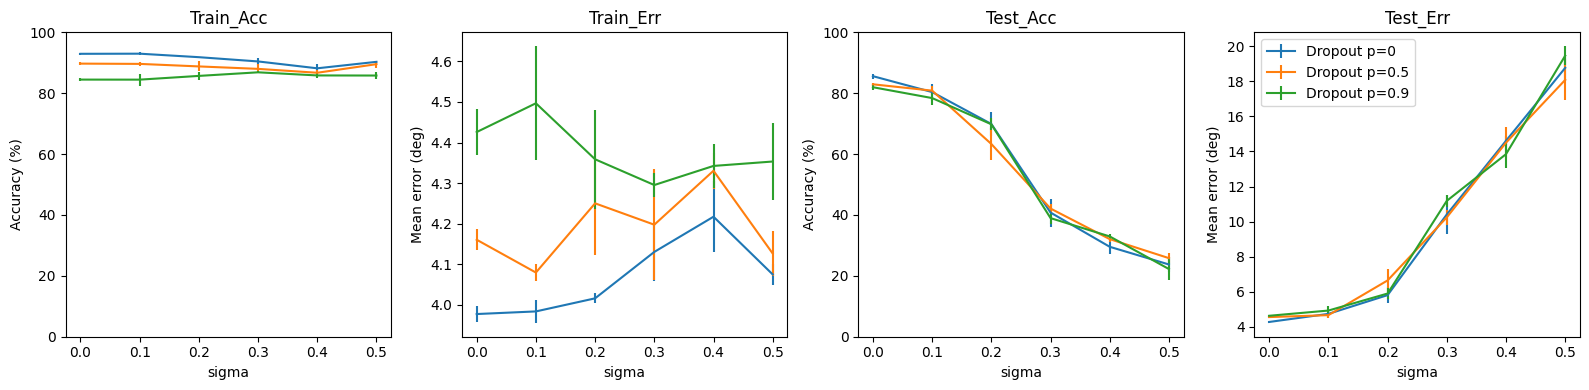

In [46]:
#Plot
from scipy.stats import sem
from statistics import mean, stdev
import math

r = {key:{f'p_{dropout}':list() for dropout in dropouts} for key in plots}
yerr = {key:{f'p_{dropout}':list() for dropout in dropouts} for key in plots}
plt.figure(figsize=(16, 4), dpi=100)
for i, plot in enumerate(plots):
    temp = 141+i
    plt.subplot(temp)
    for p in dropouts:
        r[plot][f'p_{p}'] = [mean(list(all_runs_results[x][plot][f'p_{p}'][s] for x in range(RUNS))) for s in range(len(sigmas))]
        yerr[plot][f'p_{p}'] = [stdev(list(all_runs_results[x][plot][f'p_{p}'][s] for x in range(RUNS)))/math.sqrt(RUNS) for s in range(len(sigmas))]
        plt.errorbar(sigmas, r[plot][f'p_{p}'], yerr=yerr[plot][f'p_{p}'], label=f'Dropout p={p}')
        plt.xlabel("sigma")
        plt.title(plot.title())
        if i % 2 == 0:
            plt.ylim([0, 100])
            plt.ylabel('Accuracy (%)')
        else:
            plt.ylabel('Mean error (deg)')
plt.legend()
plt.tight_layout()   

# Conclusions

* dropout doesn't do much - difference between train/test performance is smaller, but final accuracy and error remain the same. Even very high values of p don't affect training too much, probably because few neurons spike either way. Could be interesting to check if dropout activates more neurons (maybe targeted dropout affecting only the spiking neurons? though the network is probably too simple for it to be useful for this problem)
* absolute test error starts to grow moreless linearly after certain threshold
